# GTSRB classification with CNN - Dataset analysis and preparation

Inspired by the [GTSRB Fidle tutorial](https://fidle.cnrs.fr/w3/)

## 1. Imports

In [65]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time as time

from skimage import color, io, transform, exposure
from skimage.util import img_as_ubyte
from skimage.filters import rank
from skimage.morphology import disk

## 2. Parameters

In [66]:
scale = 0.2
rng = np.random.default_rng(int(time.time()))
input_dir = 'data'
output_dir = 'prepared_data'

## 3. Read the dataset

In [67]:
def read_csv_dataset(csv_file, rng, scale=1.0):
	# Read CSV file
	df = pd.read_csv(csv_file, header=0)

	# Get filenames and labels
	path = os.path.dirname(csv_file)
	filenames = df['Path'].to_list()
	labels = df['ClassId'].to_list()

	# Shuffle and reduce dataset
	combined = list(zip(filenames, labels))
	rng.shuffle(combined)
	print(f'Loaded {len(combined)} images')
	reduced_size = int(scale * len(combined))
	combined = combined[:reduced_size]
	filenames, labels = zip(*combined)

	# Load images
	images = [io.imread(f'{path}/{filename}') for filename in filenames]

	return np.array(images, dtype=object), np.array(labels)

In [68]:
# Read datasets
x_train, y_train = read_csv_dataset(f'{input_dir}/Train.csv', rng, scale)
x_test,  y_test  = read_csv_dataset(f'{input_dir}/Test.csv',  rng)
x_meta,  y_meta  = read_csv_dataset(f'{input_dir}/Meta.csv',  rng)

# Sort Meta
combined = list(zip(x_meta,y_meta))
combined.sort(key=lambda x: x[1])
x_meta,y_meta = zip(*combined)

Loaded 39209 images
Loaded 12630 images
Loaded 43 images


## 4. Few statistics about train dataset

In [69]:
train_size  = []
train_ratio = []
train_lx    = []
train_ly    = []

test_size   = []
test_ratio  = []
test_lx     = []
test_ly     = []

for image in x_train:
    (lx,ly,lz) = image.shape
    train_size.append(lx*ly/1024)
    train_ratio.append(lx/ly)
    train_lx.append(lx)
    train_ly.append(ly)

for image in x_test:
    (lx,ly,lz) = image.shape
    test_size.append(lx*ly/1024)
    test_ratio.append(lx/ly)
    test_lx.append(lx)
    test_ly.append(ly)

Number of images in train :  7841
Number of images in test  :  12630


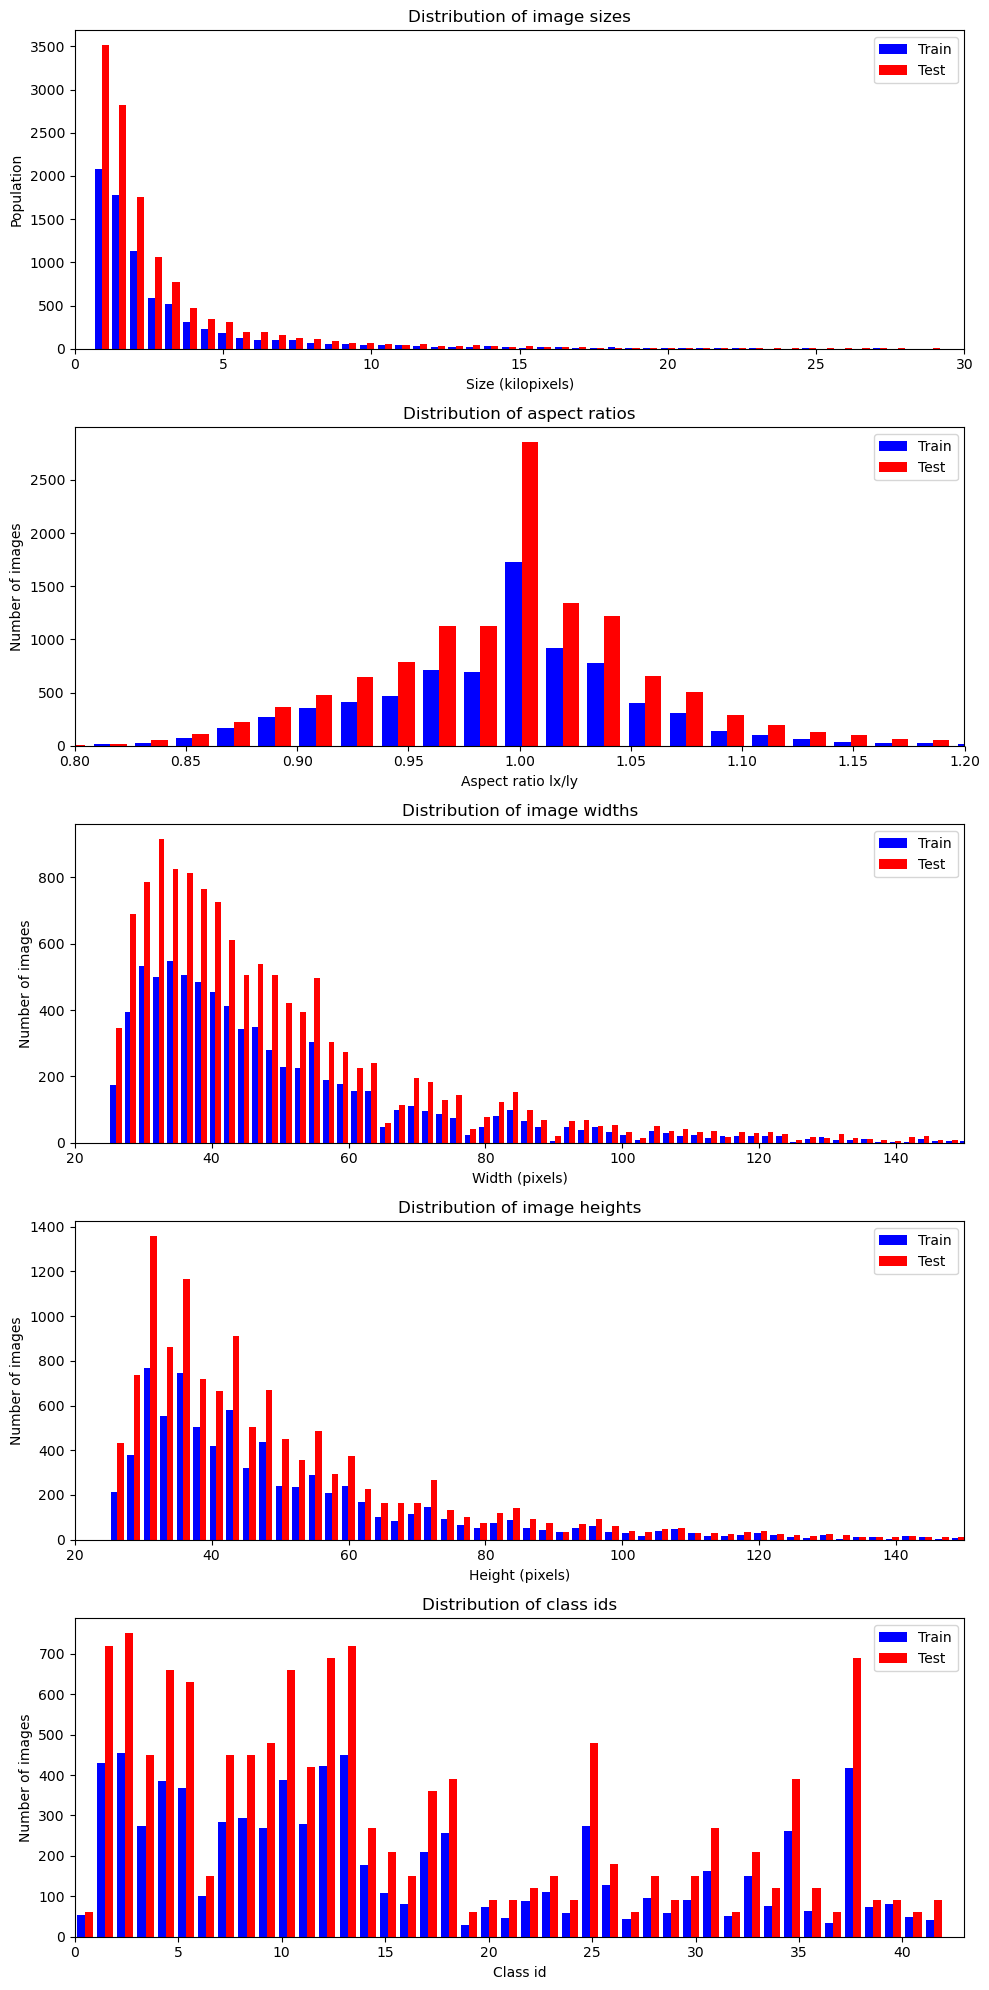

In [70]:
# Global
print("Number of images in train : ", len(x_train))
print("Number of images in test  : ", len(x_test))

fig, axs = plt.subplots(5, 1, figsize=(10, 20))

# Sizes
axs[0].hist([train_size, test_size], bins=100, color=['blue', 'red'])
axs[0].set(
	title='Distribution of image sizes',
	xlabel='Size (kilopixels)',
	ylabel='Population',
	xlim=[0, 30]
)
axs[0].legend(['Train', 'Test'])

# Ratio lx/ly
axs[1].hist([train_ratio,test_ratio], bins=100, color=['blue', 'red'])
axs[1].set(
	title='Distribution of aspect ratios',
	xlabel='Aspect ratio lx/ly',
	ylabel='Number of images',
	xlim=[0.8, 1.2]
)
axs[1].legend(['Train', 'Test'])

# lx
axs[2].hist([train_lx,test_lx], bins=100, color=['blue', 'red'])
axs[2].set(
	title='Distribution of image widths',
	xlabel='Width (pixels)',
	ylabel='Number of images',
	xlim=[20, 150]
)
axs[2].legend(['Train', 'Test'])

# ly
axs[3].hist([train_ly,test_ly], bins=100, color=['blue', 'red'])
axs[3].set(
	title='Distribution of image heights',
	xlabel='Height (pixels)',
	ylabel='Number of images',
	xlim=[20, 150]
)
axs[3].legend(['Train', 'Test'])

# Statistics / classId
axs[4].hist([y_train,y_test], bins=43, color=['blue', 'red'])
axs[4].set(
	title='Distribution of class ids',
	xlabel='Class id',
	ylabel='Number of images',
	xlim=[0, 43]
)
axs[4].legend(['Train', 'Test'])

plt.tight_layout()
plt.show()

## 5. Comparaison of theoretical and real images

In [71]:
def plot_imgs(images, labels, num_imgs, cols): # TODO: use this fonction with utils.py
	rows = (num_imgs + cols - 1) // cols

	fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
	fig.subplots_adjust(hspace=0.5, wspace=0.5)

	# Show the images
	for i in range(num_imgs):
		ax = axes[i // cols, i % cols]
		ax.imshow(images[i], cmap='gray' if images[i].shape[2] == 1 else None)
		ax.set_xlabel(labels[i])
		ax.set_xticks([])
		ax.set_yticks([])

	# Fill the empty plots with white images
	for j in range(len(y_meta), rows * cols):
		ax = axes[j // cols, j % cols]
		ax.axis('off')

	plt.show()

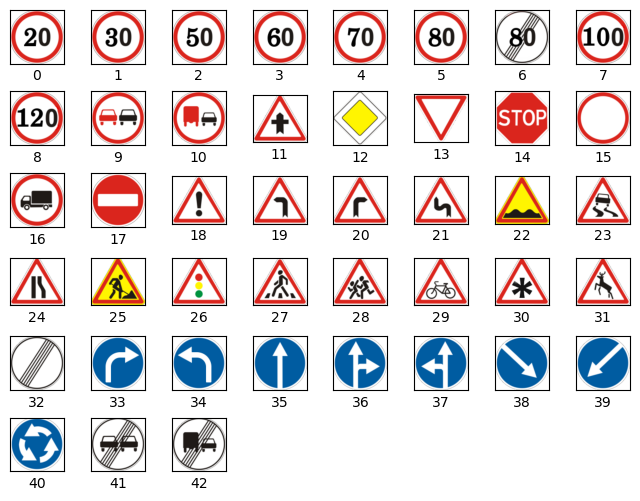

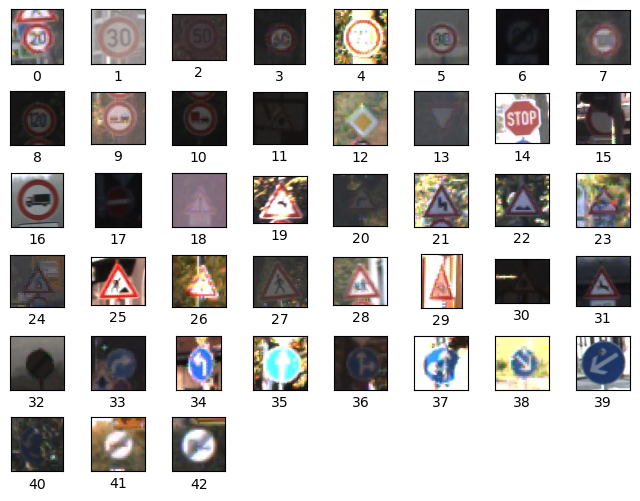

In [72]:
# Print theoretical images
plot_imgs(x_meta, y_meta, 43)

# Print real images
images = [io.imread(f'data/Train/{i}/{i:05d}_00000_00000.png') for i in range(43)]
plot_imgs(images, list(range(43)), 43)

## Step 7 - dataset cooking

In [73]:
def images_enhancement(images, width=25, height=25, proc='RGB'):
	out = []
	for img in images:
		# Turn into RGB and resize
		if img.shape[2] == 4:
			img = color.rgba2rgb(img)
		img = transform.resize(img, (width, height))


		# === Processing ===

		# RGB / Histogram Equalization
		if proc == 'RGB-HE':
			hsv = color.rgb2hsv(img.reshape(width, height, 3))
			hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
			img = color.hsv2rgb(hsv)

		# Grayscale
		elif proc == 'L':
			img = color.rgb2gray(img)

		# Grayscale / Histogram Equalization
		elif proc == 'L-HE':
			img = color.rgb2gray(img)
			img = exposure.equalize_hist(img)

		# Grayscale / Local Histogram Equalization
		elif proc == 'L-LHE':        
			img = color.rgb2gray(img)
			img = img_as_ubyte(img)
			img = rank.equalize(img, disk(10)) / 255.

		# Grayscale / Contrast Limited Adaptive Histogram Equalization
		elif proc == 'L-CLAHE':
			img = color.rgb2gray(img)
			img = exposure.equalize_adapthist(img)

		out.append(img)

	# Reshape images
	out = np.array(out, dtype='float32')
	out = out.reshape(-1, width, height, 1 if proc[0] == 'L' else 3)

	return out

EXPECTED


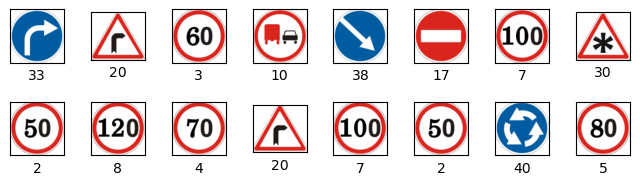

ORIGINAL


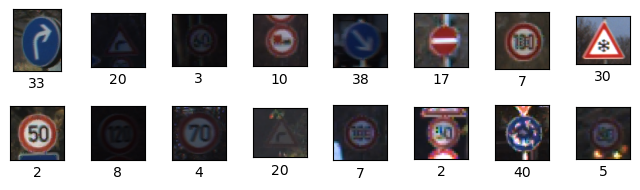

ENHANCED

Dataset: RGB  -  shape=(25, 25, 3)


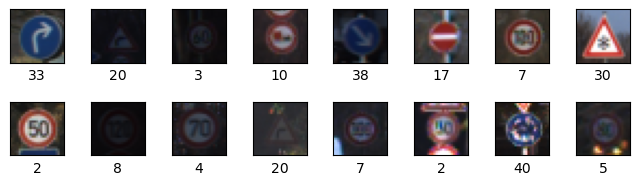

Dataset: RGB-HE  -  shape=(25, 25, 3)


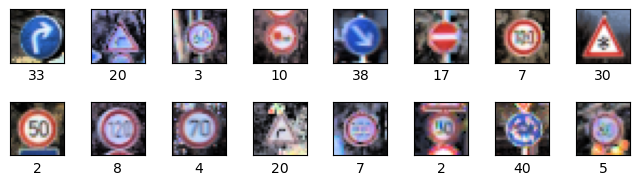

Dataset: L  -  shape=(25, 25, 1)


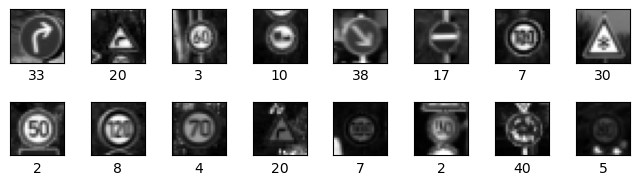

Dataset: L-HE  -  shape=(25, 25, 1)


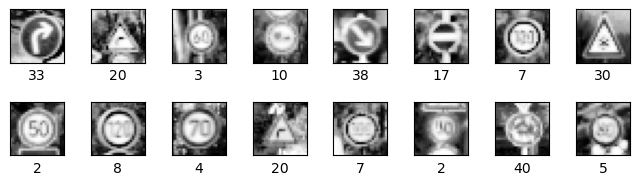

Dataset: L-LHE  -  shape=(25, 25, 1)


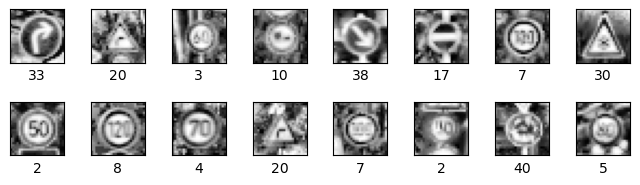

Dataset: L-CLAHE  -  shape=(25, 25, 1)


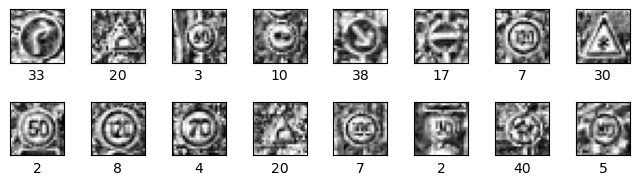

In [74]:
i = rng.integers(0, len(x_train)-16)
x_samples = x_train[i:i+16]
y_samples = y_train[i:i+16]

datasets  = {}
datasets['RGB']      = images_enhancement( x_samples, width=25, height=25, proc='RGB'  )
datasets['RGB-HE']   = images_enhancement( x_samples, width=25, height=25, proc='RGB-HE'  )
datasets['L']        = images_enhancement( x_samples, width=25, height=25, proc='L'  )
datasets['L-HE']     = images_enhancement( x_samples, width=25, height=25, proc='L-HE'  )
datasets['L-LHE']    = images_enhancement( x_samples, width=25, height=25, proc='L-LHE'  )
datasets['L-CLAHE']  = images_enhancement( x_samples, width=25, height=25, proc='L-CLAHE'  )

print('EXPECTED')
x_expected = [x_meta[i] for i in y_samples]
plot_imgs(x_expected, y_samples, 16)

print('ORIGINAL')
plot_imgs(x_samples, y_samples, 16)

print('ENHANCED\n')
for k, d in datasets.items():
	print(f"Dataset: {k}  -  shape={d.shape[1:]}")
	plot_imgs(d, y_samples, 16)

## 8. Cook and save

In [75]:
def save_h5_dataset(x_train, y_train, x_test, y_test, x_meta, y_meta, filename):

	# Create h5 file
	with h5py.File(filename, "w") as f:
		f.create_dataset("x_train", data=x_train)
		f.create_dataset("y_train", data=y_train)
		f.create_dataset("x_test",  data=x_test)
		f.create_dataset("y_test",  data=y_test)
		f.create_dataset("x_meta",  data=x_meta)
		f.create_dataset("y_meta",  data=y_meta)

	size = os.path.getsize(filename) / (1024 * 1024)
	print(f'Dataset: {filename}   \tshape: {x_train.shape}\tsize: {size:.1f} Mo')

In [76]:
# Print parameters
print(f'scale is          : {scale}')
print(f'x_train length is : {len(x_train)}')
print(f'x_test  length is : {len(x_test)}')
print(f'output dir is     : {output_dir}\n')

# Prepare output directory
os.makedirs(output_dir, exist_ok=True)

all_size= [24, 48]
all_proc=['RGB', 'RGB-HE', 'L', 'L-LHE']

for s in all_size:
	for m in all_proc:
		# Prepare datasets
		x_train_new = images_enhancement(x_train, width=s, height=s, proc=m)
		x_test_new  = images_enhancement(x_test,  width=s, height=s, proc=m)
		x_meta_new  = images_enhancement(x_meta,  width=s, height=s, proc='RGB')

		# Save datasets
		filename = f'{output_dir}/set-{s}x{s}-{m}.h5'
		save_h5_dataset(x_train_new, y_train, x_test_new, y_test, x_meta_new, y_meta, filename)

# Free memory
x_train_new, x_test_new = 0, 0

scale is          : 0.2
x_train length is : 7841
x_test  length is : 12630
output dir is     : prepared_data

Dataset: prepared_data/set-24x24-RGB.h5   	shape: (7841, 24, 24, 3)	size: 135.4 Mo
Dataset: prepared_data/set-24x24-RGB-HE.h5   	shape: (7841, 24, 24, 3)	size: 135.4 Mo
Dataset: prepared_data/set-24x24-L.h5   	shape: (7841, 24, 24, 1)	size: 45.4 Mo
Dataset: prepared_data/set-24x24-L-LHE.h5   	shape: (7841, 24, 24, 1)	size: 45.4 Mo
Dataset: prepared_data/set-48x48-RGB.h5   	shape: (7841, 48, 48, 3)	size: 541.1 Mo
Dataset: prepared_data/set-48x48-RGB-HE.h5   	shape: (7841, 48, 48, 3)	size: 541.1 Mo
Dataset: prepared_data/set-48x48-L.h5   	shape: (7841, 48, 48, 1)	size: 181.2 Mo
Dataset: prepared_data/set-48x48-L-LHE.h5   	shape: (7841, 48, 48, 1)	size: 181.2 Mo


## 9. Reload data to be sure

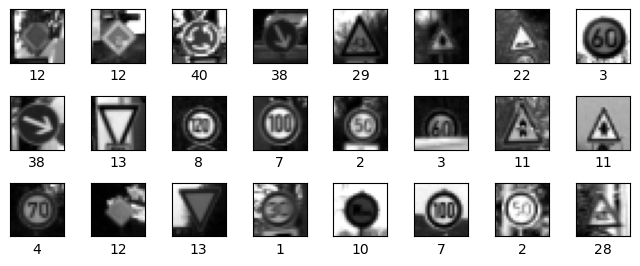

In [77]:
dataset = 'set-24x24-L'
samples = range(24)

# Load dataset
with h5py.File(f'{output_dir}/{dataset}.h5','r') as f:
	x_tmp = f['x_train'][:]
	y_tmp = f['y_train'][:]

# Print images
plot_imgs(x_tmp, y_tmp, 24)

# Free memory
x_tmp, y_tmp = 0, 0